# Comparing and Evaluating Clustering Algorithms

Validating clustering results and compare the results among clustering algorithms is a big challenge. Aiming to show these challenges in practice, here we'll compare k-means, agglomerative clustering, and DBSCAN using real world datasets.

## Evaluating clustering with ground truth

Having a ground truth in the real-world is improbable. But, comparing clustering results using ground truth is very useful for scientific purposes.
Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) are two metrics that provide a quantitative measure with an optimum of 1 and a value of 0 for unrelated clusterings. See below an example.

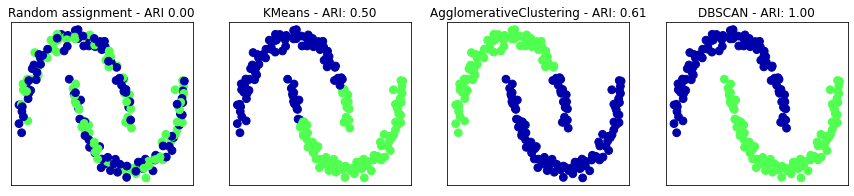

In [5]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

#rescale the data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

#list of algorithms
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

#create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

#plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI {:.2f}".format(adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(y, clusters)))

Okay. As we can see (and as expected) DBSCAN is the best choice as it produces the highest ARI for this particular dataset.

## Evaluating clustering without ground truth


As I mentioned, in practice we usually don't have any ground truth. There are scoring metrics that requires no ground truth like silhouette coefficient. However, these don't work well in practice.

Silhouette coefficient computes the compactness of a cluster, while higher is better with a perfect score of 1. Compact clusters are good, but compactness  doesn't allow for complex shapes.

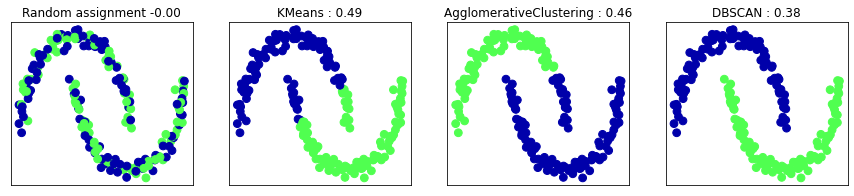

In [8]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

#rescale the data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

#list of algorithms
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

#create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

#plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment {:.2f}".format(silhouette_score(X_scaled, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))

KMeans is the best choice according to silhouette_score, even though we know DBSCAN produces the (real) best results.
A slightly better strategy for evaluating clusters is using robustness-based clustering metrics. These run an algorithm after adding some noise to the data, or using different parameter settings, and compare the outcomes. The idea is simple, if the algorithm performs well even with many perturbations, it is likely to be trustworthy. To sum up, we'll never know if clustering results will be useful. We need to manually analyze each cluster.

## Comparing algorithms on the faces dataset


Let's see if we can find interesting patterns on faces dataset using $k$-means, DBSCAN and agglomerative clustering.

### DBSCAN

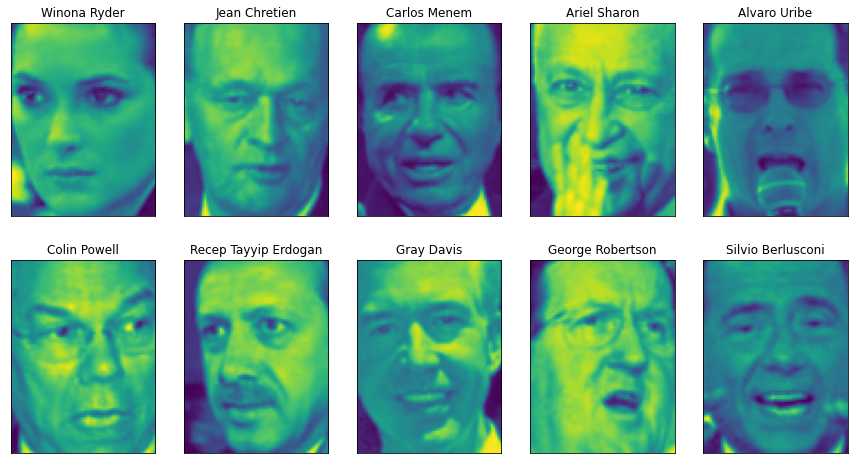

In [10]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [11]:
# Sample each class with 50 examples.
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

In [12]:
# extract eigenfaces from lfw data and transform data
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

In [14]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


In [15]:
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [  32 2031]


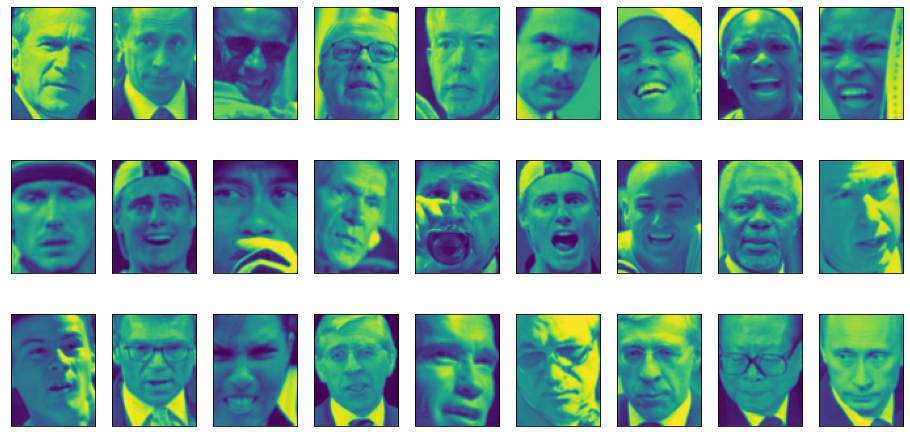

In [18]:
noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(16, 8))

for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [19]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
     print("\neps={}".format(eps))
     dbscan = DBSCAN(eps=eps, min_samples=3)
     labels = dbscan.fit_predict(X_pca)
     print("Clusters present: {}".format(np.unique(labels)))
     print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Clusters present: [-1]
Cluster sizes: [2063]

eps=3
Clusters present: [-1]
Cluster sizes: [2063]

eps=5
Clusters present: [-1]
Cluster sizes: [2063]

eps=7
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
Clusters present: [-1  0  1  2]
Cluster sizes: [1307  750    3    3]

eps=11
Clusters present: [-1  0]
Cluster sizes: [ 413 1650]

eps=13
Clusters present: [-1  0]
Cluster sizes: [ 120 1943]


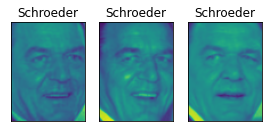

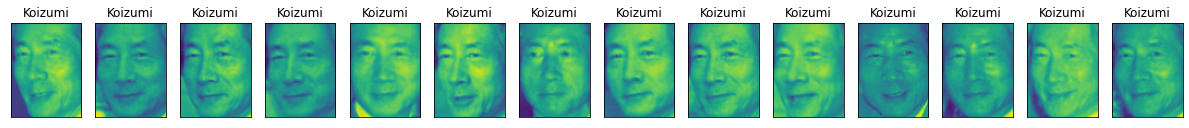

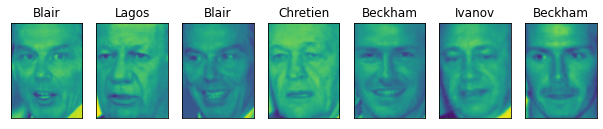

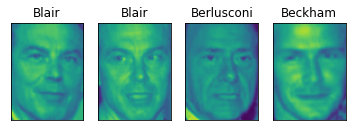

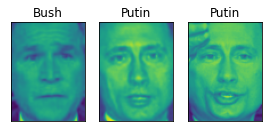

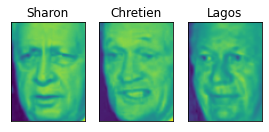

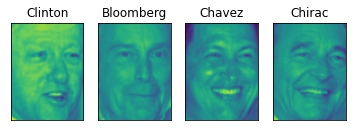

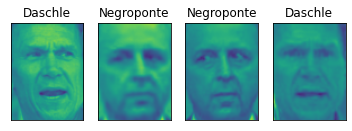

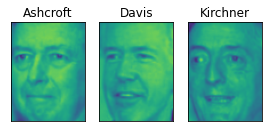

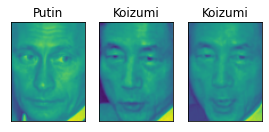

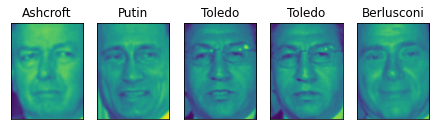

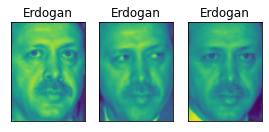

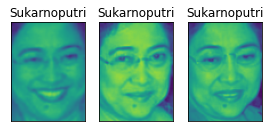

In [20]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)
for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4), subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

### $k$-Means

In [21]:
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [282 226 105 268 151 324 202 208 208  89]


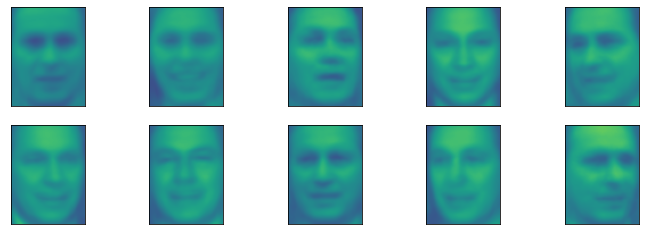

In [22]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0, vmax=1)

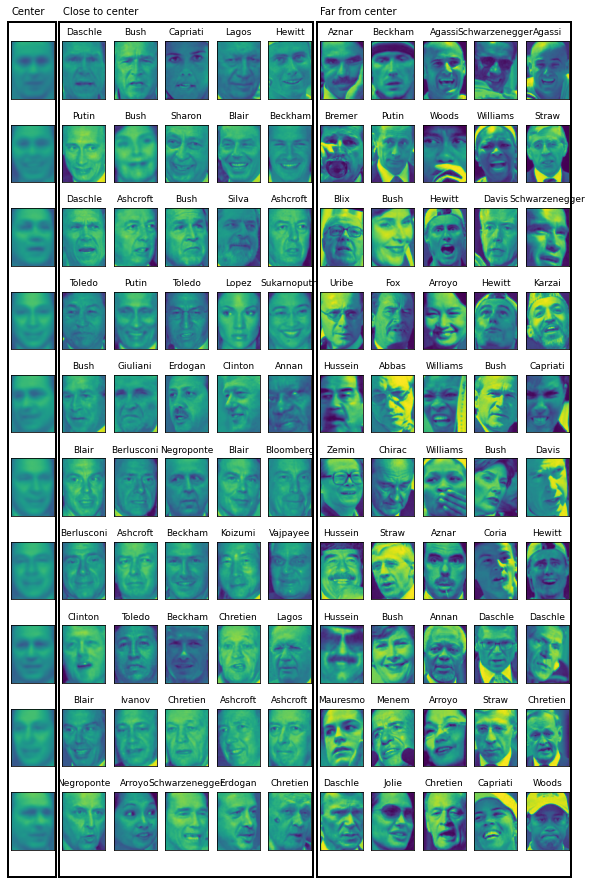

In [23]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people, y_people, people.target_names)


### Agglomerative clustering.

In [24]:
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("Cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

Cluster sizes agglomerative clustering: [169 660 144 329 217  85  18 261  31 149]


In [25]:
print("ARI: {:.2f}".format(adjusted_rand_score(labels_agg, labels_km)))

ARI: 0.10


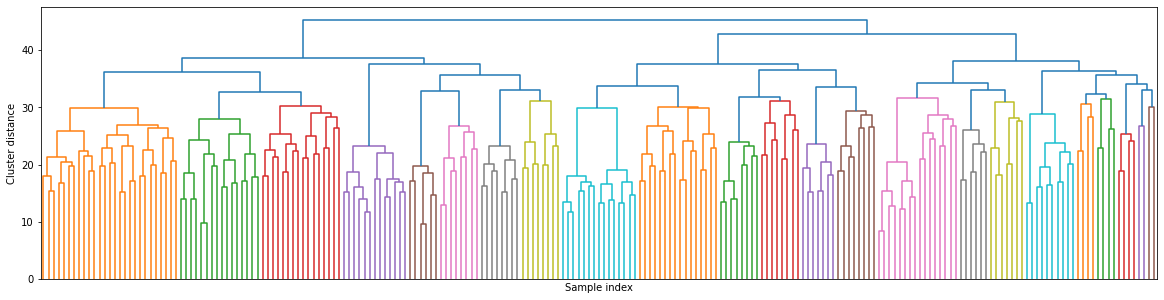

In [29]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_array = ward(X_pca)
# now we plot the dendrogram for the linkage_array
# containing the distances between clusters
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance");

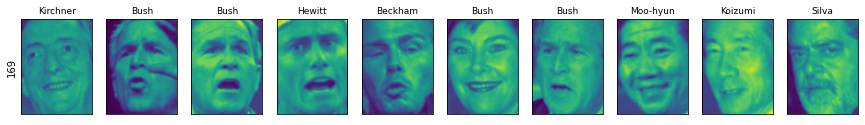

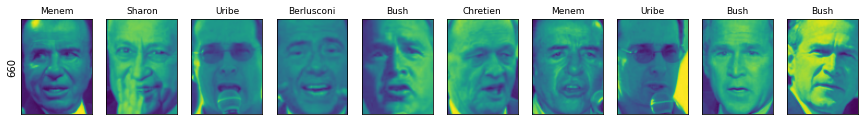

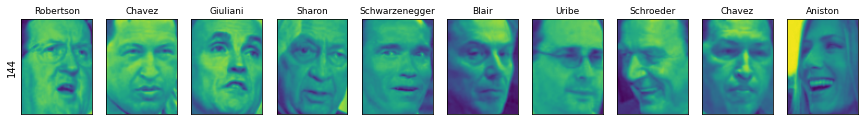

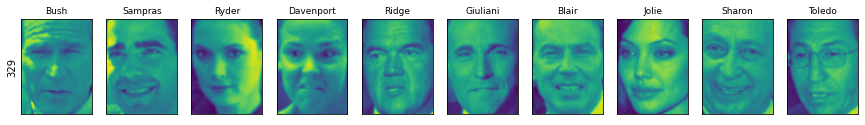

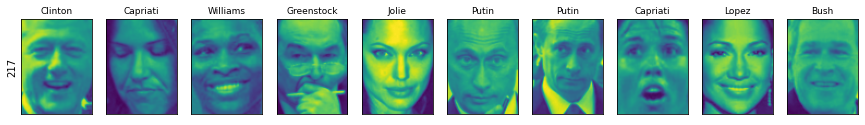

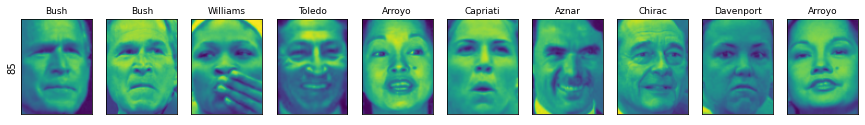

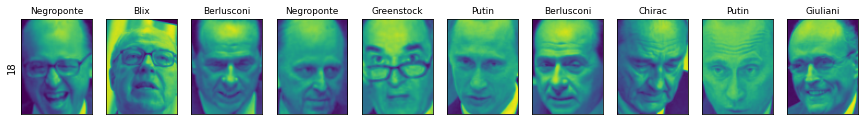

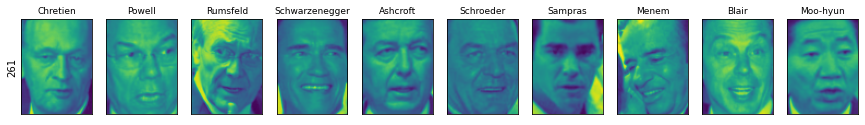

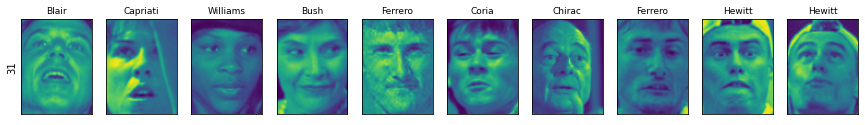

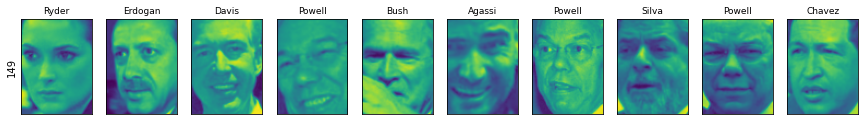

In [30]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()},
    figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9});

cluster sizes agglomerative clustering: [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


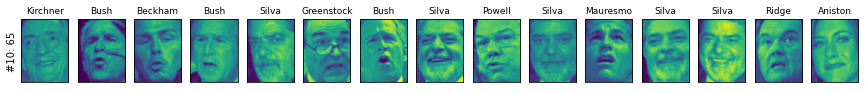

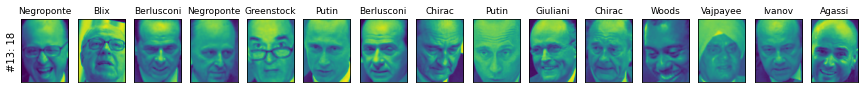

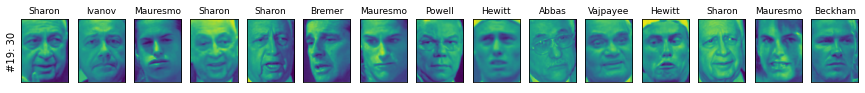

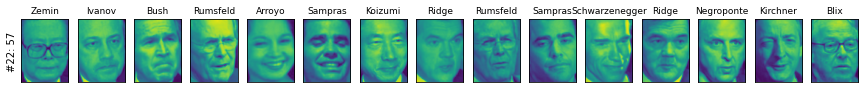

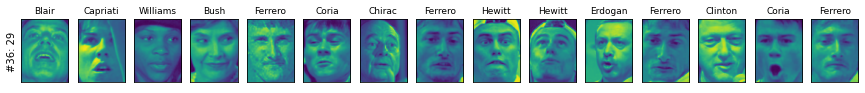

In [35]:
# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))
n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()},
    figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
        fontdict={'fontsize': 9})
    for i in range(cluster_size, 15):
        axes[i].set_visible(False);